In [1]:
import sys
import pytorch_lightning as pl
import torch 
import torch.nn as nn 
from torchmetrics import __version__ as torchmetrics_version
from torchmetrics import Accuracy
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms
from pytorch_lightning.callbacks import ModelCheckpoint


In [2]:
print(torchmetrics_version)
print(pl.__version__)

1.7.1
2.5.1.post0


### Define pl.LightningModule
* methods include
  + \_\_init\_\_
    + define network architecture and model
  + forward
    + call model on input data and return results
  + training_step
    + calculate loss and return loss for each batch
    + update metrics such as accuracy for each batch
    + log batch loss
  + validation_step
  + test_step
    + calculate loss and accuracy for each batch
    + log accuracy (compute accuracy for log) and loss for each batch
    + return loss for each batch
  + on_training_epoch_end
    +  log accuracy (compute accuracy for log)
    +  reset accuracy
  + on_validation_epoch_end
    + log accuracy (compute accuracy for log)
    +  reset accuracy
  + on_test_epoch_end
    + log accuracy (compute accuracy for log)
    +  reset accuracy
  + config_optimizer
    + set up and config optimizer

In [3]:
# define lightningModule
class MultiLayerModel(pl.LightningModule):
    def __init__(self, image_shape=(1, 28, 28), hidden_units=(32, 16)):
        super().__init__()
        self.train_acc = Accuracy(task="multiclass", num_classes=10)
        self.validation_acc = Accuracy(task="multiclass", num_classes=10)
        self.test_acc = Accuracy(task="multiclass", num_classes=10)
        input_size = image_shape[0] * image_shape[1] * image_shape[2]

        all_layers = [nn.Flatten()]

        for hidden_unit in hidden_units:
            all_layers.append(nn.Linear(input_size, hidden_unit))
            all_layers.append(nn.ReLU())
            input_size = hidden_unit

        all_layers.append(nn.Linear(hidden_units[-1], 10))

        self.model = nn.Sequential(*all_layers)        

    def forward(self, x):
        return self.model(x)

    # implement training_step in terms of batch and batch_idx
    # this is similar to Dataset index
    def training_step(self, batch, batch_idx):
        x, y = batch

        logits = self(x)
        loss = torch.nn.functional.cross_entropy(self(x), y)
        self.train_acc.update(torch.argmax(logits, dim=1), y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def on_training_epoch_end(self):
        self.log("train_acc", self.train_acc.compute())
        self.train_acc.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch

        logits = self(x)
        loss = torch.nn.functional.cross_entropy(self(x), y)
        self.test_acc.update(torch.argmax(logits, dim=1), y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_acc.compute(), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        logits = self(x)
        loss = torch.nn.functional.cross_entropy(self(x), y)
        self.validation_acc.update(torch.argmax(logits, dim=1), y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.validation_acc.compute(), prog_bar=True)
        return loss
        

    def on_validation_epoch_end(self):
        self.log("val_acc", self.validation_acc.compute())
        self.validation_acc.reset()

    def on_test_epoch_end(self):
        self.log("test_acc", self.test_acc.compute())
        self.test_acc.reset()
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)   

### Define pl.LightningDataModule

In [4]:
from torchvision import transforms
class MnistDataModule(pl.LightningDataModule):
    def __init__(self, data_path="../data/"):
        super().__init__()
        self.data_path = data_path
        self.transform = transforms.Compose([transforms.ToTensor()])

    # download dataset to the specified path
    def prepare_data(self):
        MNIST(root=self.data_path, download=True)

    # setup process applied to fit, predict, validate and test processes/functions
    def setup(self, stage=None):
        mnist_all = MNIST(
            root=self.data_path,
            train=True,
            download=False,
            transform=self.transform
        )

        self.train, self.val = random_split(mnist_all, [55000, 5000], generator=torch.Generator().manual_seed(1))
        self.test = MNIST(
        root=self.data_path,
        train=False,
        download=False,
        transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=64, num_workers=10, persistent_workers=True)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=64, num_workers=8)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=64, num_workers=8)
        

### Define pl.Trainer
* set up a callback checkpoint with metrics to selec the top k models
* initialize a pl.Trainer with checkpoint, number of epochs and gpu
* call trainer.fit(model, data_module)

In [5]:
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger("lightning_logs", name="my_experiment")
torch.manual_seed(1)

callbacks = [ModelCheckpoint(save_top_k=1, mode="max", monitor="val_acc")]

if torch.cuda.is_available():
    trainer = pl.Trainer(max_epochs=20, callbacks=callbacks, accelerator="gpu",  # Specifies GPU usage
    devices=1, check_val_every_n_epoch=2, logger=logger)
else:
    trainer = pl.Trainer(max_epochs = 20, callbacks=callbacks, check_val_every_n_epoch=2, logger=logger)

model = MultiLayerModel()
datamodule = MnistDataModule()

trainer.fit(model, datamodule)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_acc      | MulticlassAccuracy | 0      | train
1 | validation_acc | MulticlassAccuracy | 0      | train
2 | test_acc       | MulticlassAccuracy | 0      | train
3 | model          | Sequential         | 25.8 K | train
--------------------------------------------------------------
25.8 K    Trainable params
0         Non-trainable para

Sanity Checking: |                                                                               | 0/? [00:00<?, ?it/s]

C:\Users\huang\anaconda3\envs\gpu\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|████████████████████████████████████████████| 860/860 [00:18<00:00, 45.37it/s, v_num=3, train_loss=0.521]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████| 860/860 [00:18<00:00, 45.29it/s, v_num=3, train_loss=0.420, val_loss=0.241, val_acc=0.923]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|█████████████| 860/860 [00:19<00:00, 44.21it/s, v_num=3, train_loss=0.331, val_loss=0.197, val_acc=0.938]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|█████████████| 860/860 [00:18<00:00, 45.36it/s, v_num=3, train_loss=0.299, val_loss=0.179, val_acc=0.944]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|█████████████| 860/860 [00

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|███████████| 860/860 [00:26<00:00, 32.12it/s, v_num=3, train_loss=0.0857, val_loss=0.177, val_acc=0.954]


In [6]:
trainer.test(model=model, datamodule=datamodule, ckpt_path='best')


Restoring states from the checkpoint path at lightning_logs\my_experiment\version_3\checkpoints\epoch=19-step=17200.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at lightning_logs\my_experiment\version_3\checkpoints\epoch=19-step=17200.ckpt
C:\Users\huang\anaconda3\envs\gpu\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 50.43it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9570000171661377     │
│         test_loss         │    0.15849566459655762    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.15849566459655762, 'test_acc': 0.9570000171661377}]

### Evaluating Models by TensorBoard
* load tensorboard ext
* define logdir

#### Try the following processes:
* run the following code in notebook:
`%load_ext tensorboard`
`%tensorboard --logdir lightning_logs\my_experiment --host 127.0.0.1 --port 6060`

* if this doesn't work, run the following code from a terminal
`tensorboard --logdir C:\Users\huang\Documents\pytorch\lightning_logs\my_experiment --host 127.0.0.1 --port 6060`

* if the port has been occupied, run the following code:                       
  * `netstat -ano | findstr 6060` to find the process id that occupies the port
  * `taskkill /PID 6060 /F`
    

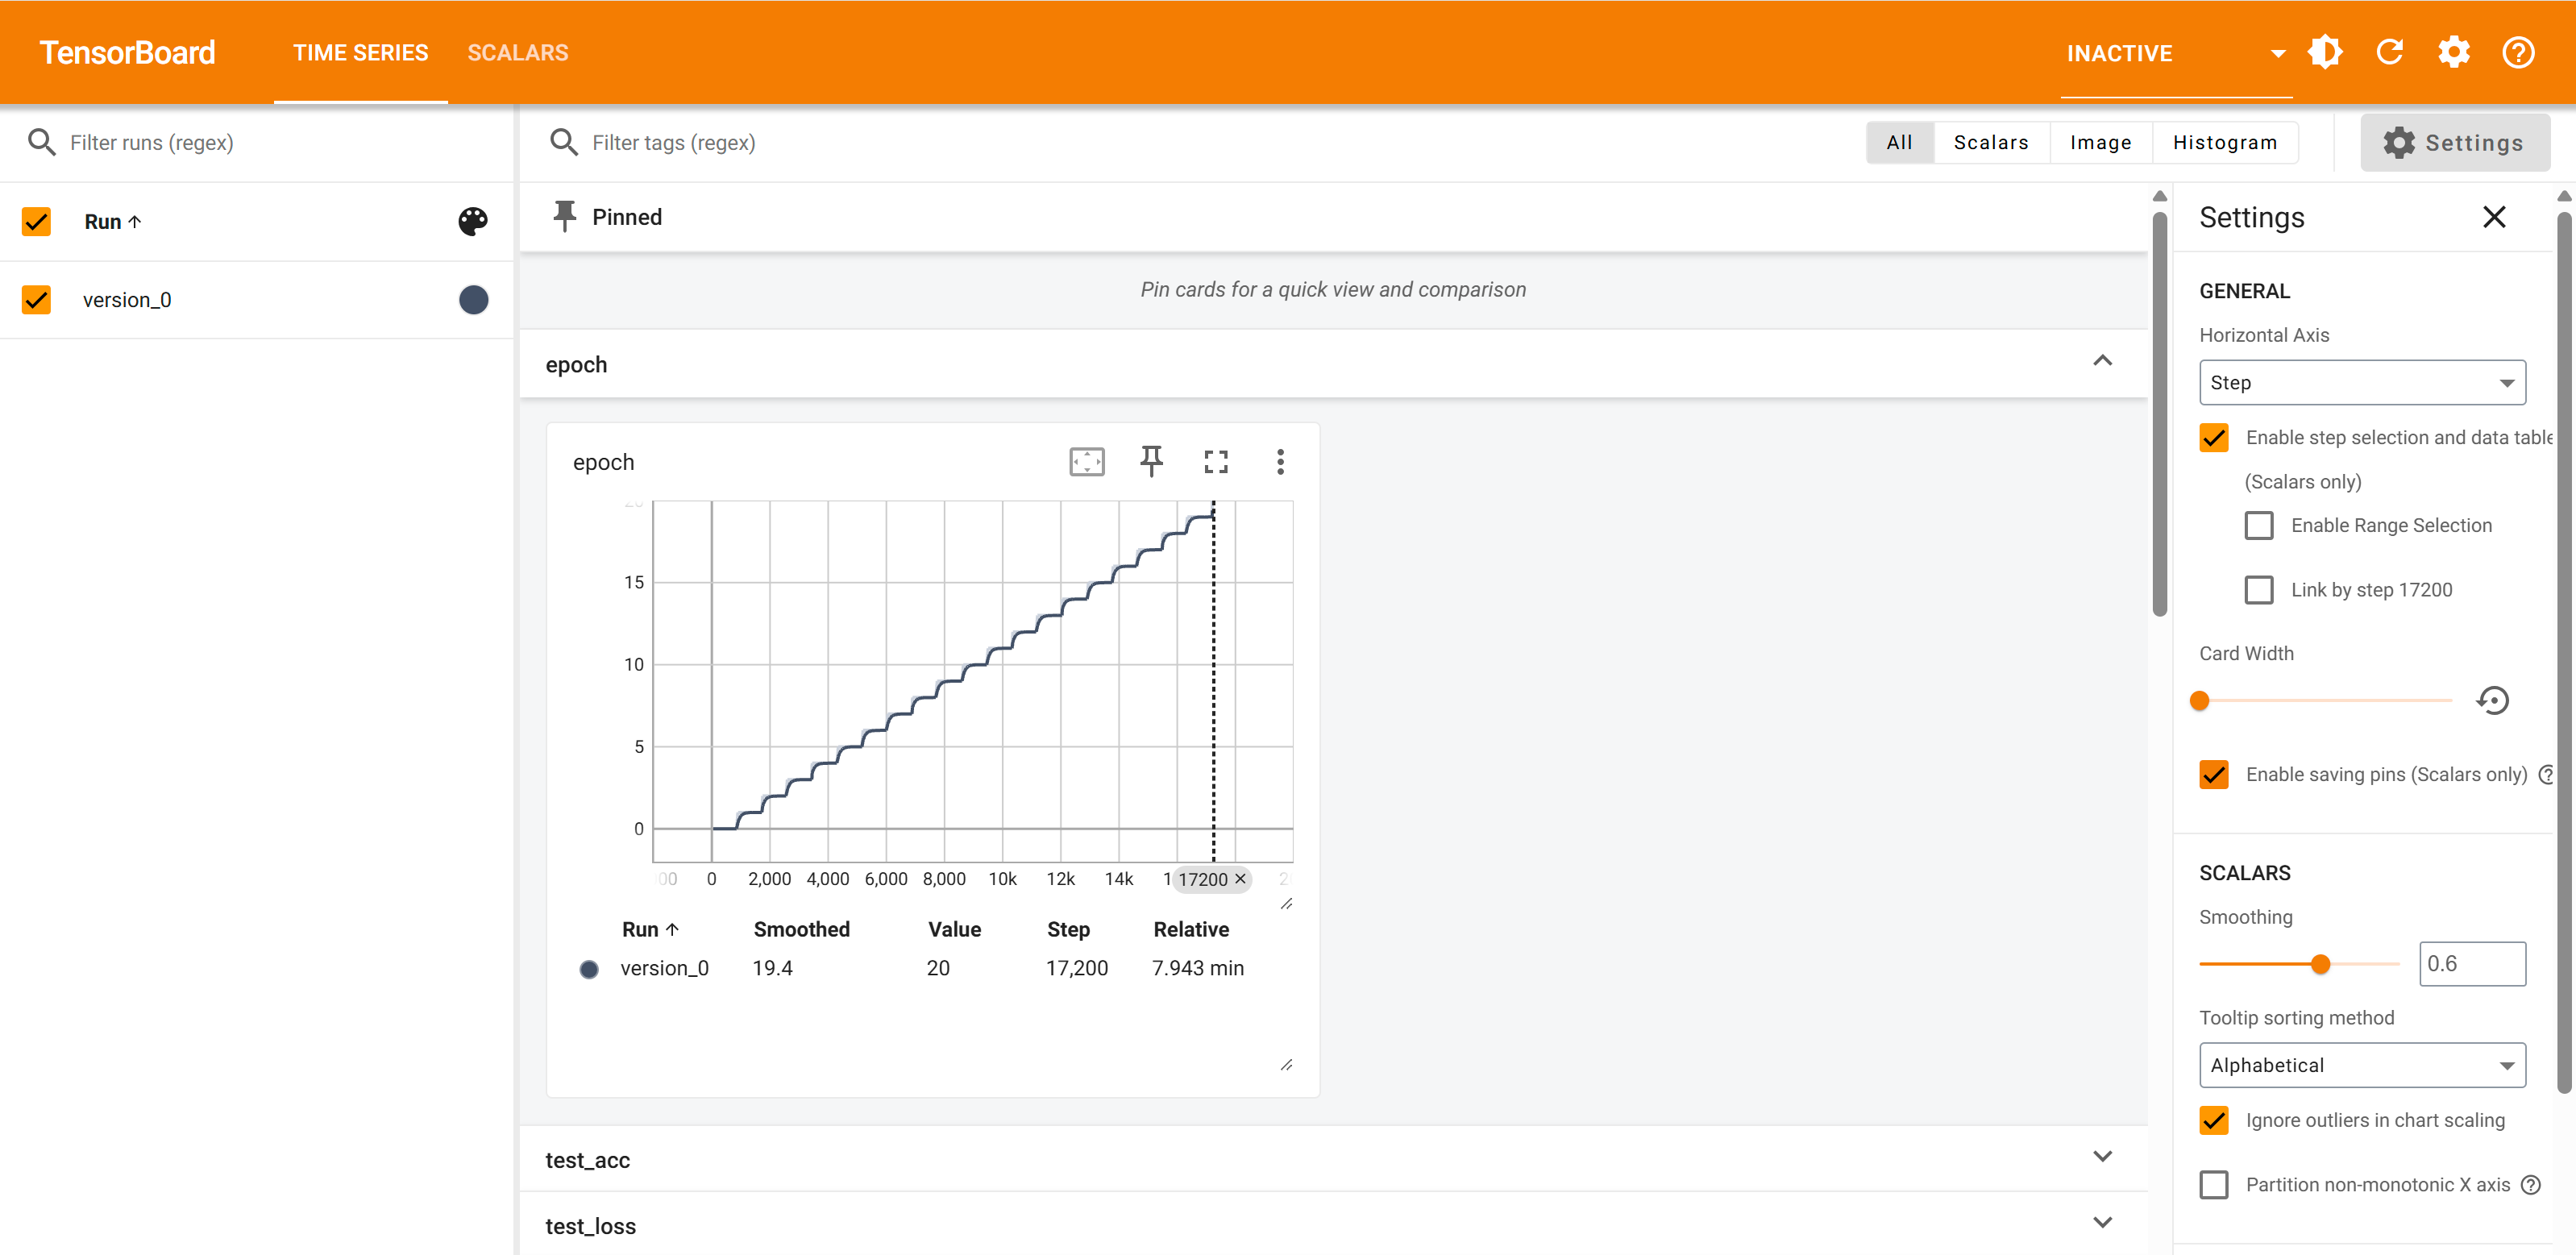

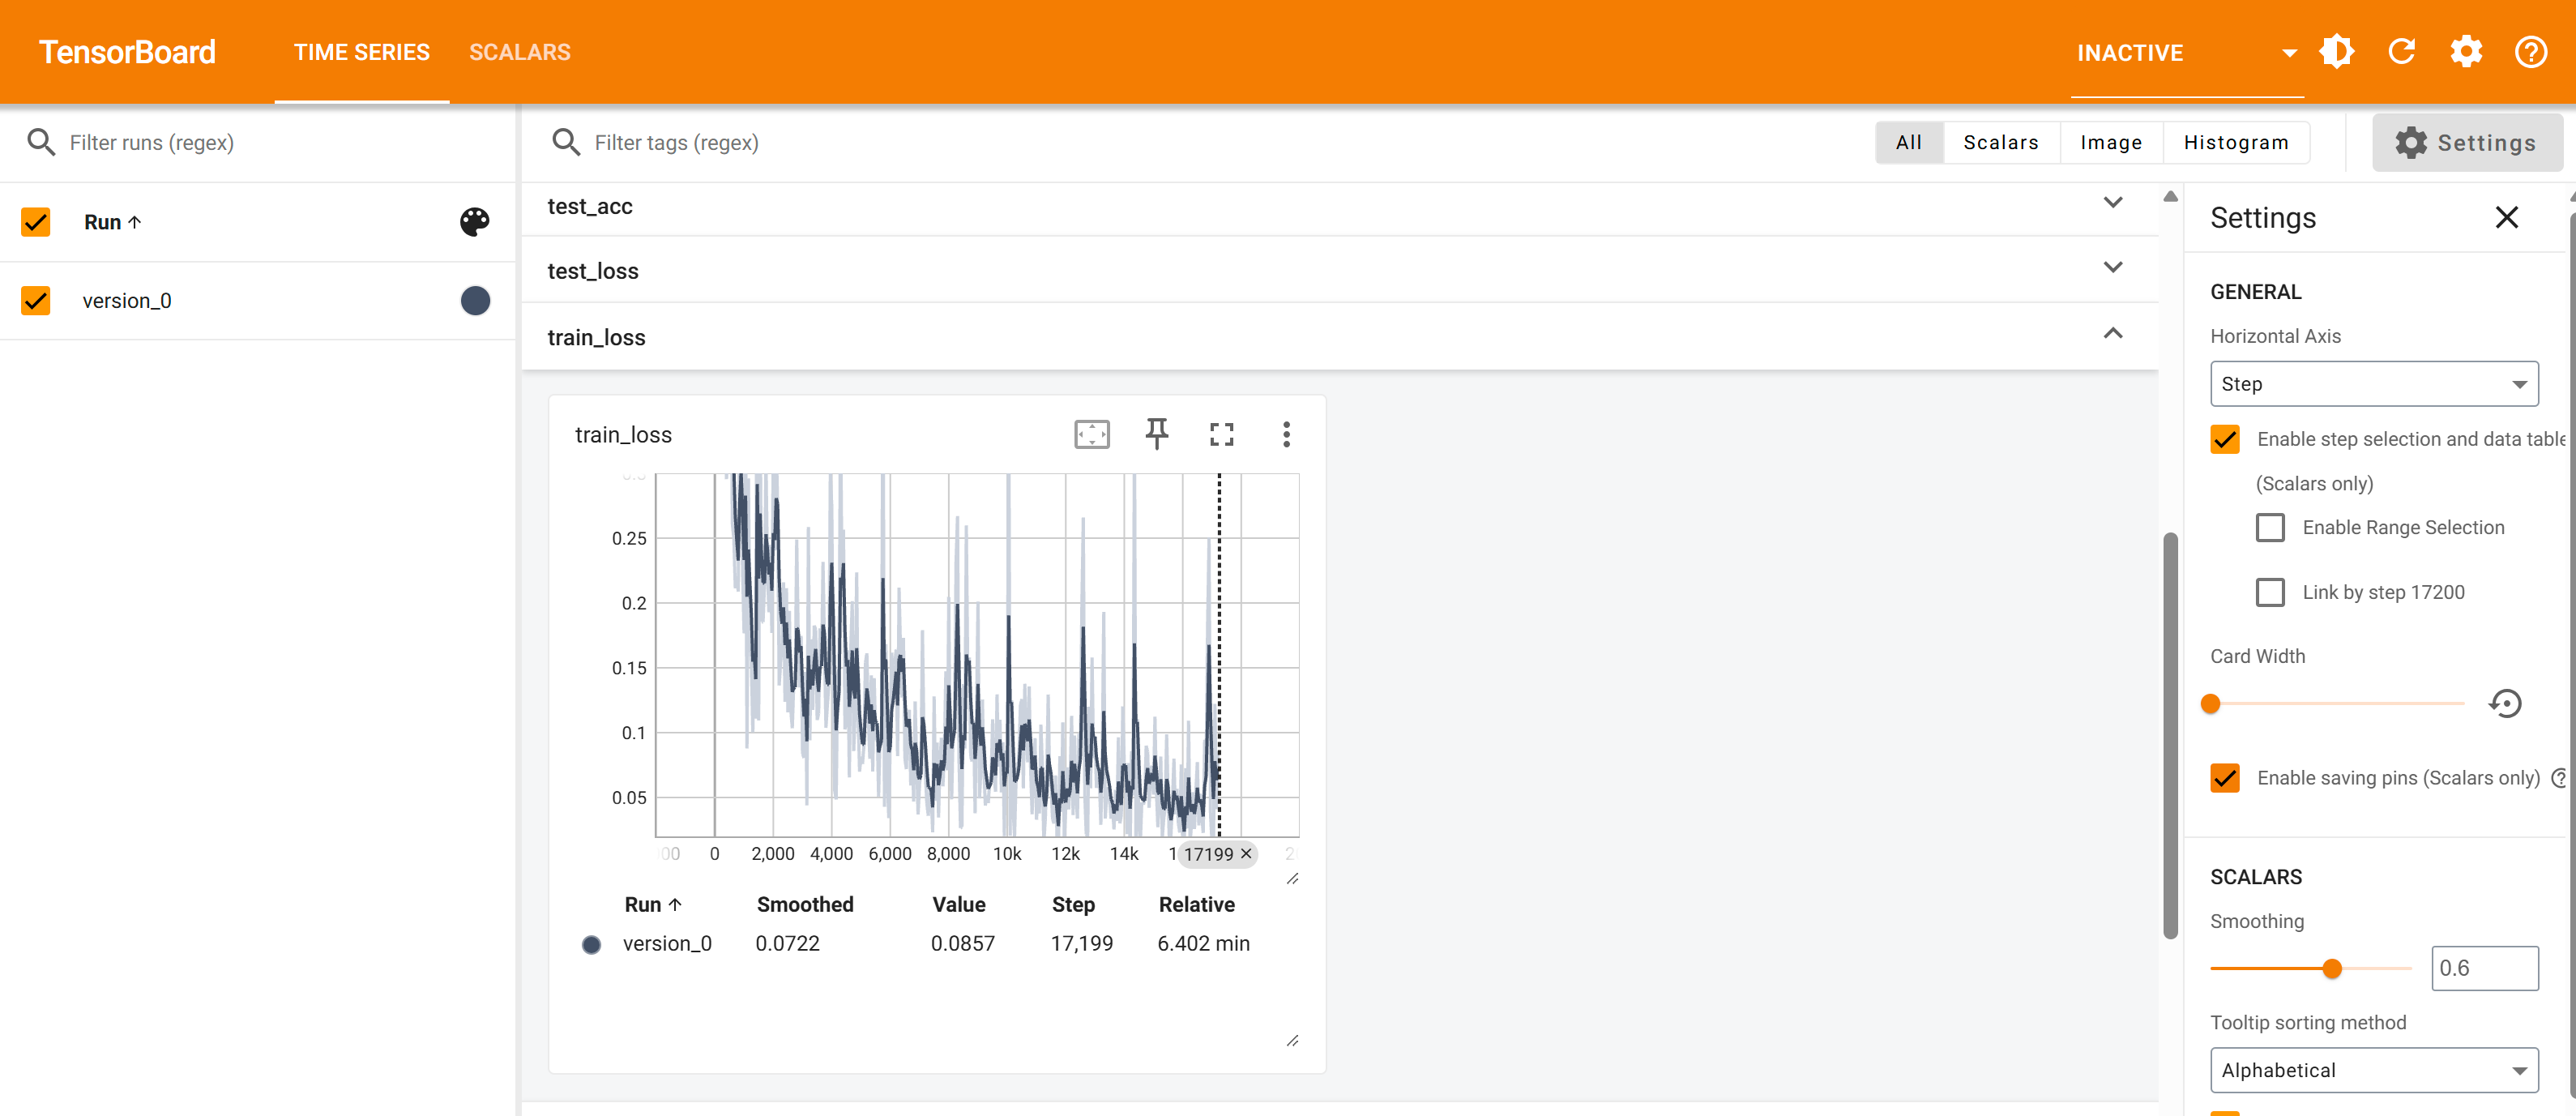

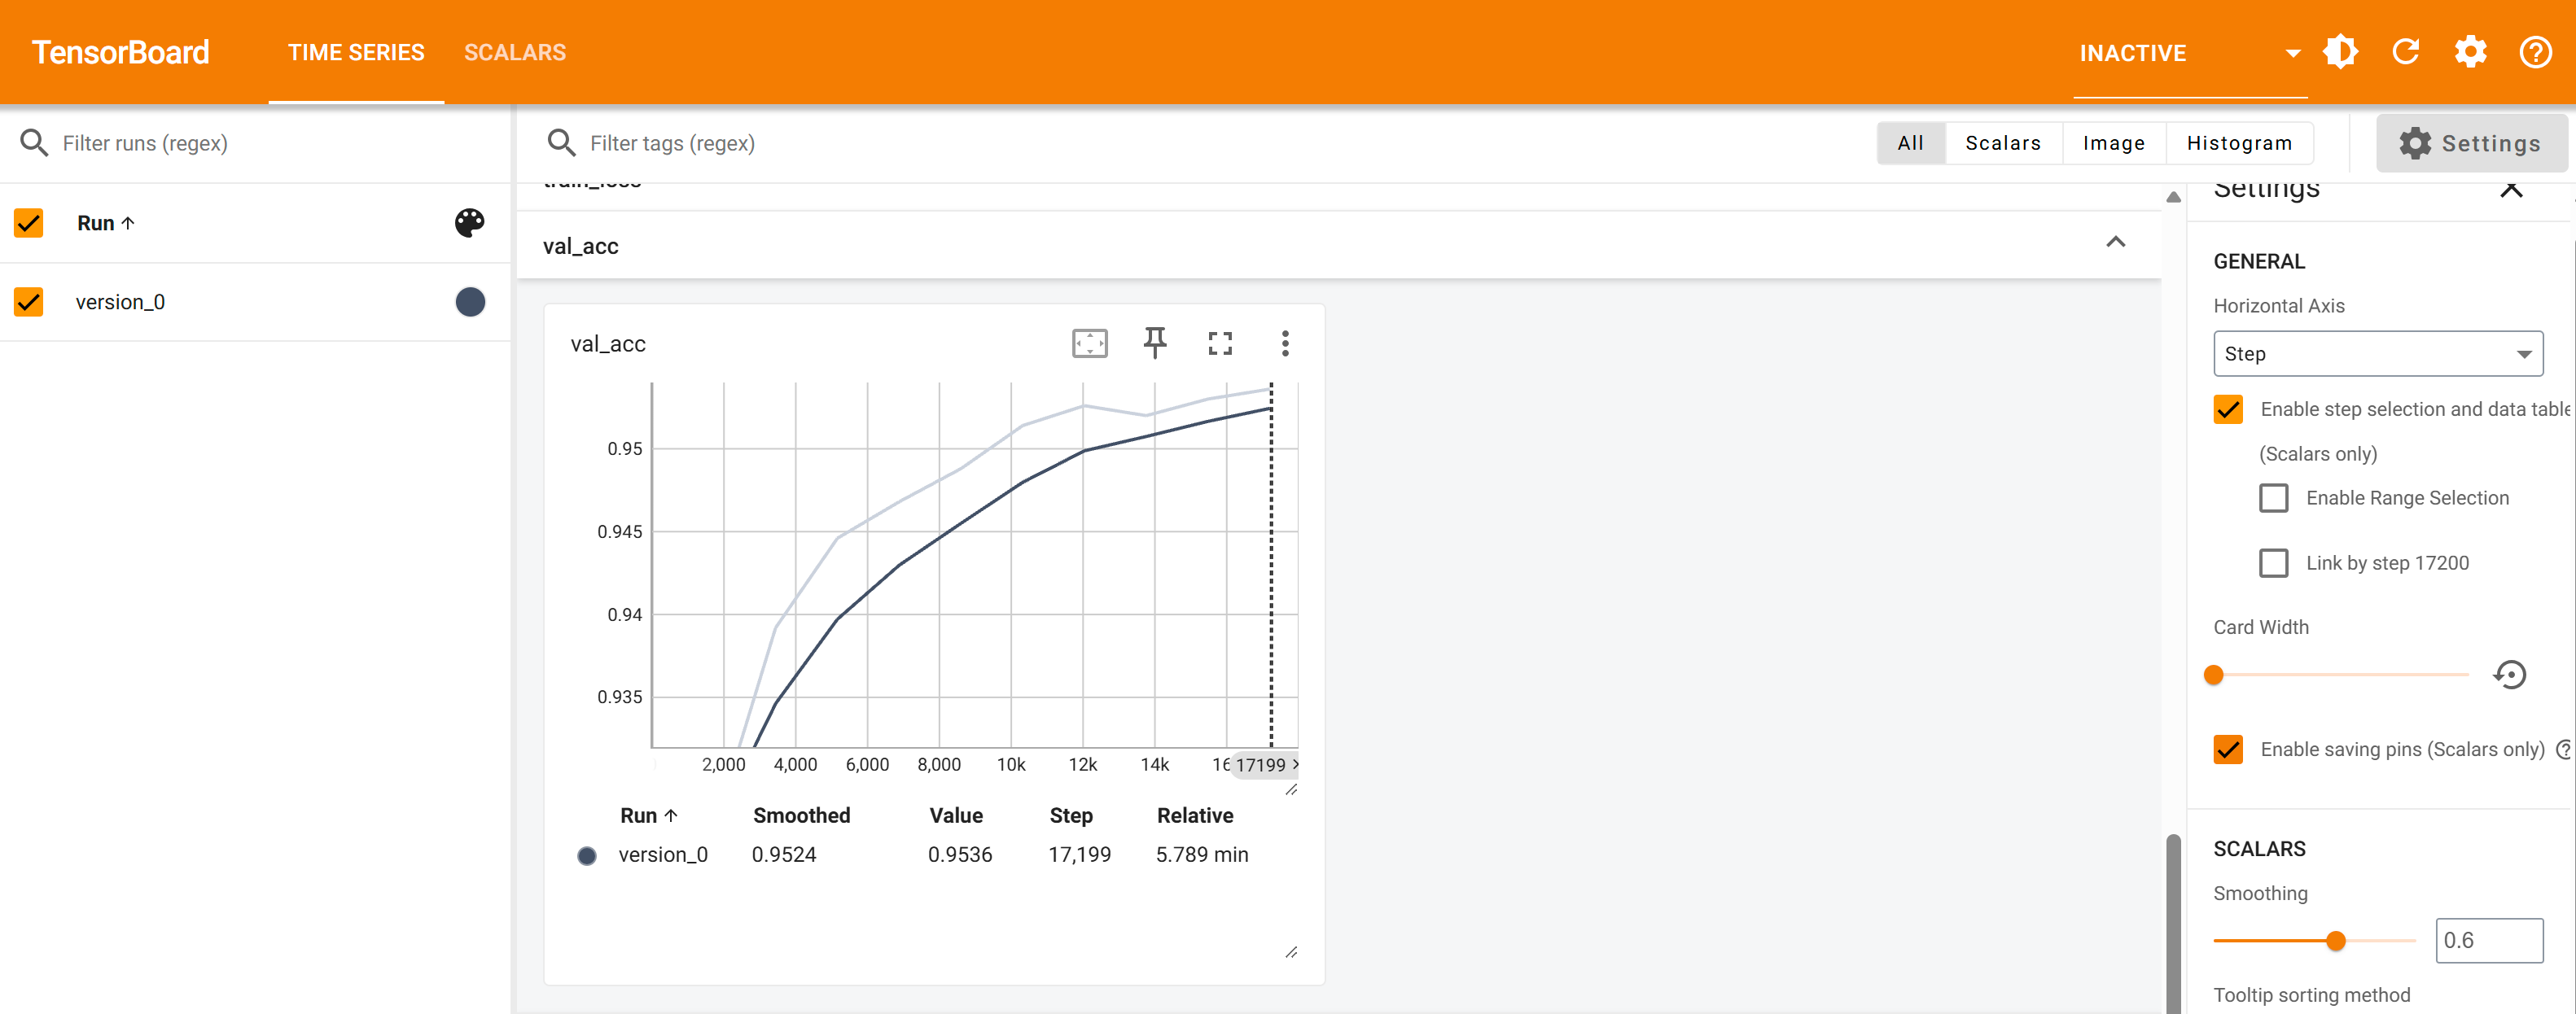

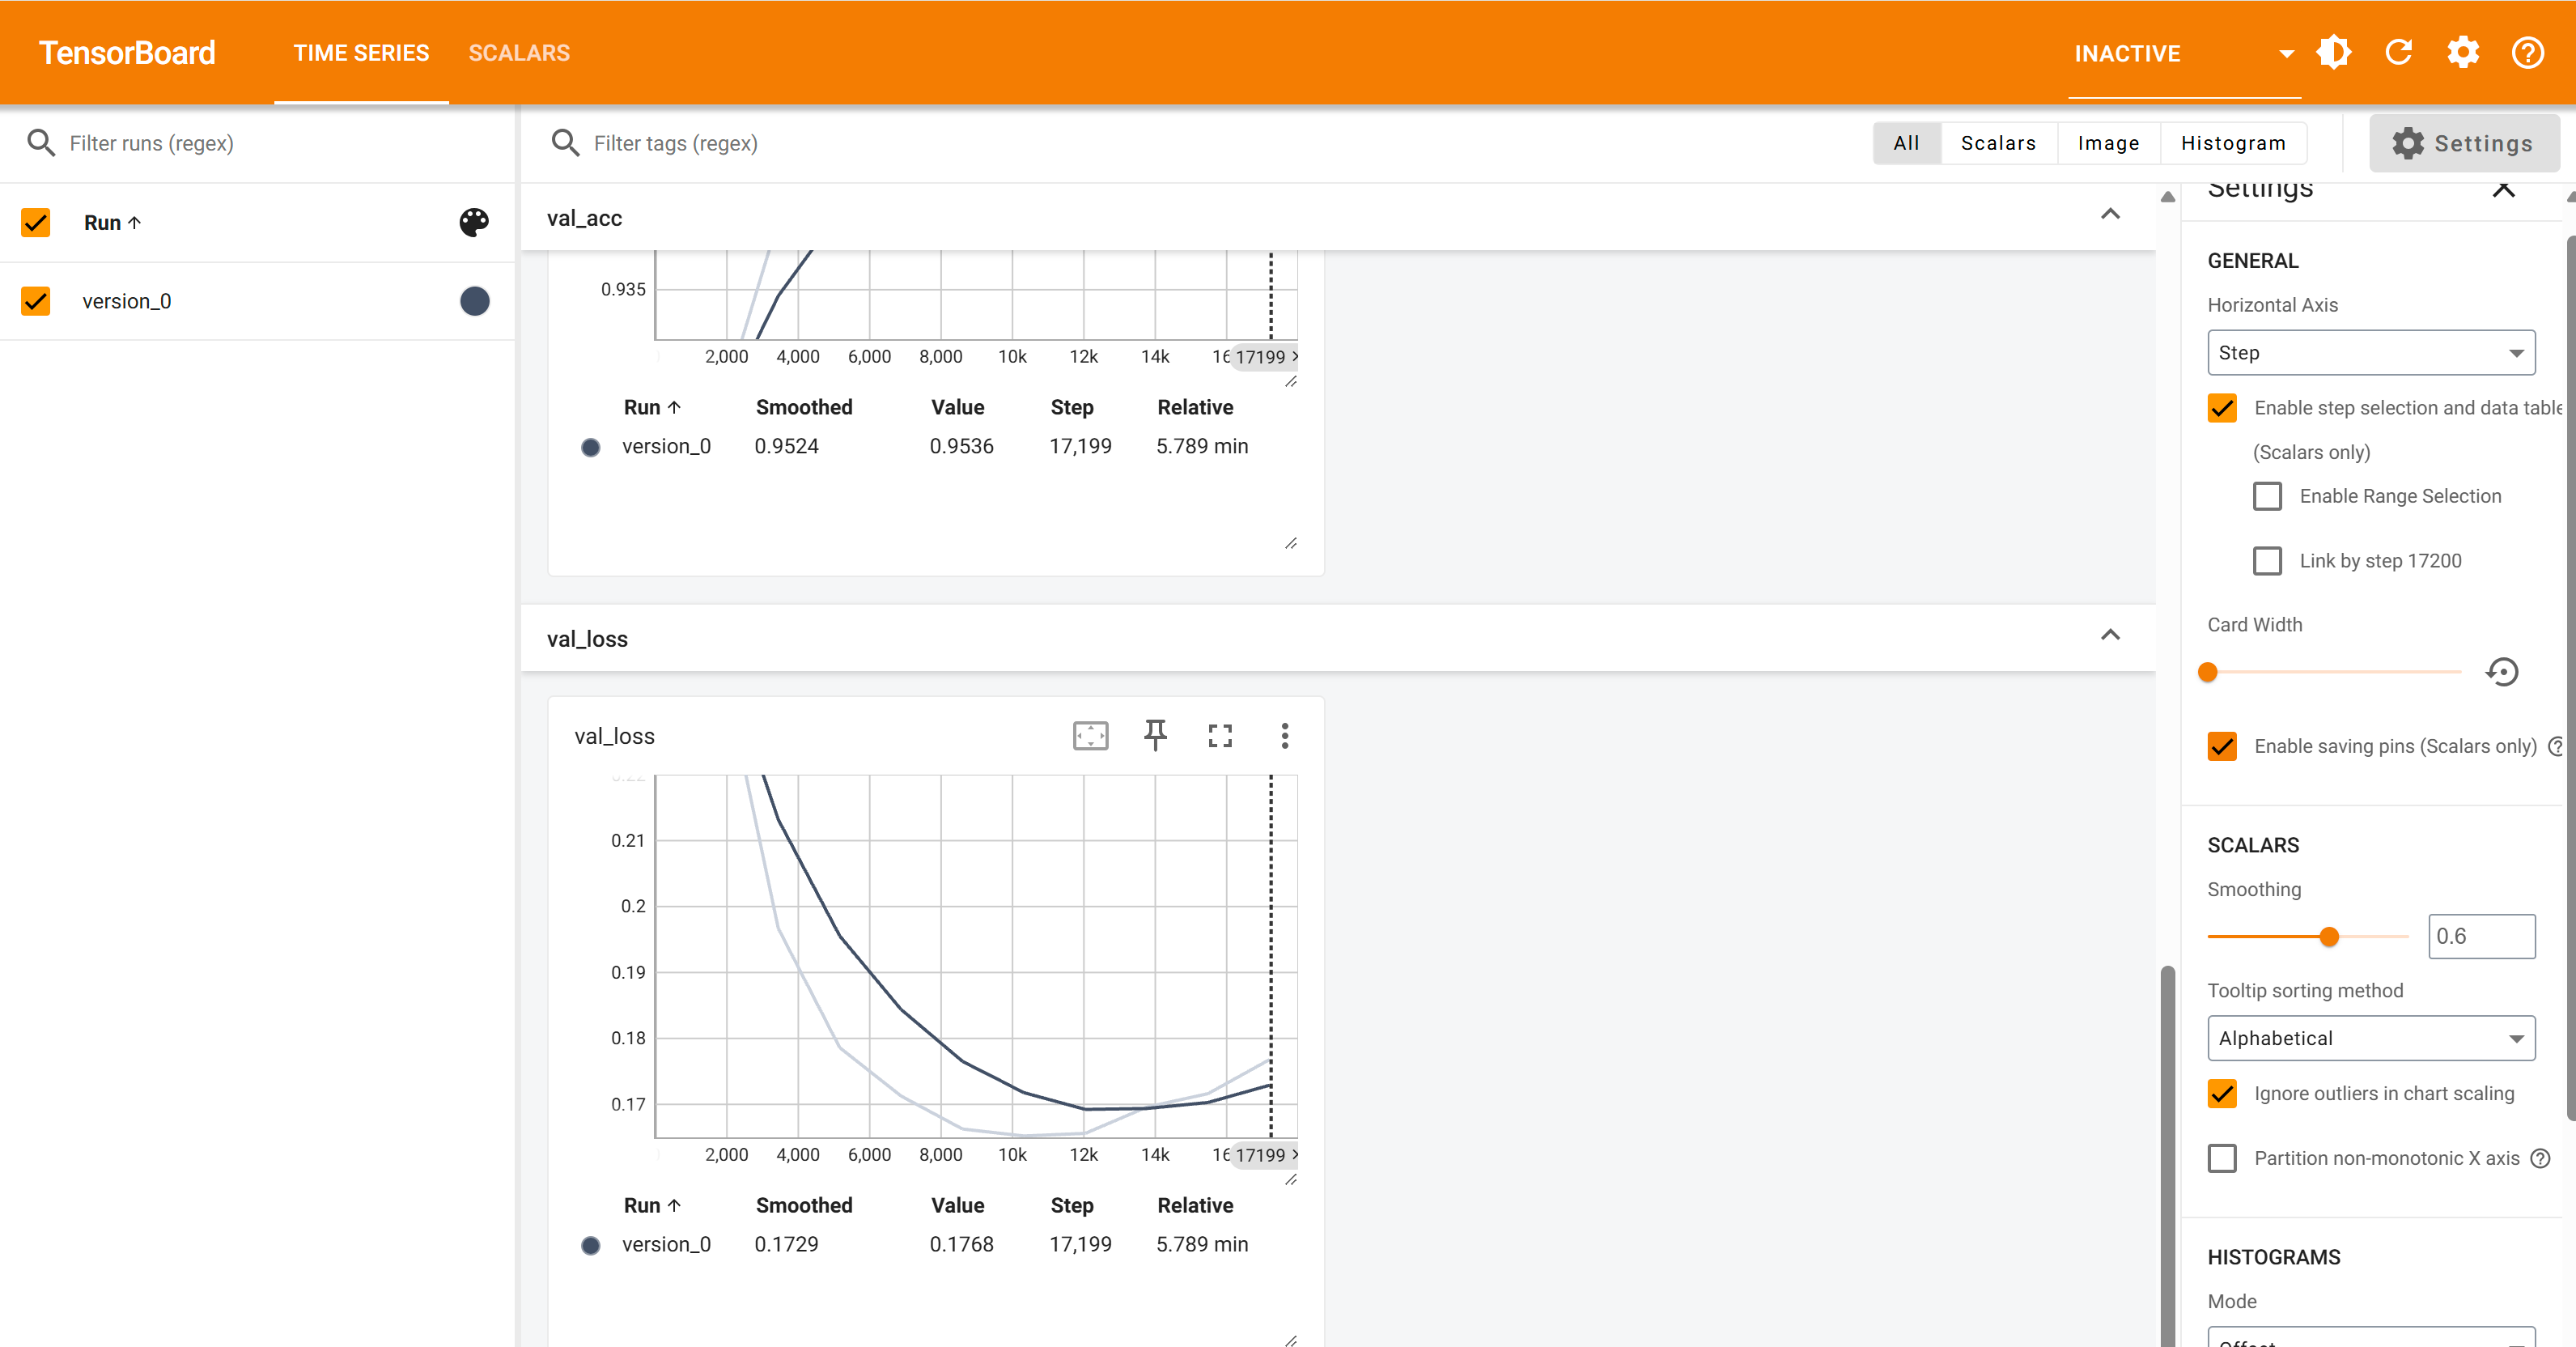